## Building a Deep Face Detection Model using Tensorflow

### 1. Setup and Get Data

#### 1.1 Install Dependencies and setup

In [1]:
# !pip install labelme opencv-python albumentations -v

#### 1.2 Collect Images using OpenCV

In [2]:
import os
import time
import uuid
import cv2

In [3]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 30

In [4]:
# cap = cv2.VideoCapture(0)
# for imgnum in range(number_images):
#     print("Collecting image {}".format(imgnum))
#     ret, frame = cap.read()
#     imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
#     cv2.imwrite(imgname, frame)
#     cv2.imshow('frame', frame)
#     time.sleep(0.5)

#     if cv2.waitKey(1) & 0xFF==ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()

#### 1.3 Annotate Images with LabelMe

In [5]:
# !labelme

### 2. Review Dataset and Build Image Loading Function

#### 2.1 Import TF and Deps

In [6]:
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

2024-10-23 05:31:06.965488: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-23 05:31:07.293451: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-23 05:31:07.298175: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-23 05:31:09.561081: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### 2.2 Limit GPY Memory Growth

In [7]:
# # Avoid OOM errors by setting GPU Memory Consumption Growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

#### 2.3 Load Image into TF Data Pipeline

In [9]:
# images = tf.data.Dataset.list_files('data/images/*.jpg')
# buffer_size = len(images)
# images.as_numpy_iterator().next()

In [10]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [11]:
# images = images.map(load_image)
# images = images.shuffle(buffer_size)

In [12]:
# images.as_numpy_iterator().next()

In [13]:
# type(images)

#### 2.4 View Raw Images with Matplotlib

In [14]:
# image_generator = images.batch(4).as_numpy_iterator()

In [15]:
# plot_images = image_generator.next()

In [16]:
# fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# for idx, image in enumerate(plot_images):
#     ax[idx].imshow(image)
# plt.show()

### 3. Partition Unaugmented Data

#### 3.1 MANUALLY SPLIT DATA INTO TRAIN TEST AND VAL

#### 3.2 Move the Matching Labels

In [17]:
# for folder in ['train', 'test', 'val']:
#     for file in os.listdir(os.path.join('data', folder, 'images')):
#         filename = file.split('.')[0]+'.json'
#         existing_filepath = os.path.join('data', 'labels', filename)
#         if os.path.exists(existing_filepath):
#             new_filepath = os.path.join('data', folder, 'labels', filename)
#             os.replace(existing_filepath, new_filepath)

#### 4. Apply Image Augmentation on Images and Labels using Albumentations

#### 4.1 Setup Albumentations Transform Pipeline

In [18]:
img = cv2.imread(os.path.join('data', 'train', 'images', '2ac88e8c-9077-11ef-86fe-00155d8a6b54.jpg'))

In [19]:
img.shape

(480, 640, 3)

In [20]:
import albumentations as alb

In [21]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                        alb.RandomGamma(p=0.2), alb.RGBShift(p=0.2),
                        alb.VerticalFlip(p=0.5)],
                       bbox_params=alb.BboxParams(format="albumentations",
                                                 label_fields=['class_labels']))

#### 4.2 Load a test image and annotation with OpenCV and JSON

In [22]:
img = cv2.imread(os.path.join('data', 'train', 'images', '2ac88e8c-9077-11ef-86fe-00155d8a6b54.jpg'))
img

array([[[190, 189, 179],
        [191, 190, 180],
        [191, 190, 180],
        ...,
        [ 66, 154, 191],
        [ 71, 154, 192],
        [ 74, 157, 195]],

       [[190, 189, 179],
        [191, 190, 180],
        [191, 190, 180],
        ...,
        [ 67, 155, 192],
        [ 69, 154, 192],
        [ 69, 154, 192]],

       [[191, 190, 180],
        [192, 191, 181],
        [193, 191, 181],
        ...,
        [ 64, 155, 194],
        [ 65, 153, 193],
        [ 66, 153, 193]],

       ...,

       [[105, 105,  65],
        [ 96,  97,  57],
        [ 88,  89,  50],
        ...,
        [ 49, 144, 188],
        [ 48, 142, 185],
        [ 49, 143, 186]],

       [[103, 104,  62],
        [ 94,  95,  55],
        [ 86,  87,  48],
        ...,
        [ 49, 144, 188],
        [ 46, 139, 184],
        [ 47, 140, 185]],

       [[ 97,  98,  56],
        [ 91,  92,  52],
        [ 86,  87,  48],
        ...,
        [ 47, 142, 186],
        [ 44, 137, 182],
        [ 46, 139, 184]]

In [23]:
with open(os.path.join('data', 'train', 'labels', '2ac88e8c-9077-11ef-86fe-00155d8a6b54.json'), 'r') as f:
    label = json.load(f)

In [24]:
label

{'version': '5.5.0',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[272.2988505747126, 169.8850574712644],
    [451.60919540229884, 403.2183908045977]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {},
   'mask': None}],
 'imagePath': '..\\images\\2ac88e8c-9077-11ef-86fe-00155d8a6b54.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYn

In [25]:
label['shapes'][0]['label']

'face'

#### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [26]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [27]:
coords

[272.2988505747126, 169.8850574712644, 451.60919540229884, 403.2183908045977]

In [28]:
coords = list(np.divide(coords, [640, 480, 640, 480]))

In [29]:
coords

[0.42546695402298845,
 0.35392720306513414,
 0.7056393678160919,
 0.8400383141762452]

#### 4.4 Apply Augmentations and View Results

In [30]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [31]:
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [32]:
augmented['image'].shape

(450, 450, 3)

In [33]:
augmented['bboxes']

[(0.09420178799489143,
  0.10618135376756077,
  0.49266922094508303,
  0.6246998722860791)]

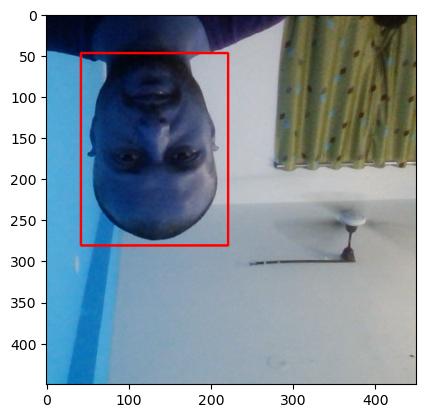

In [34]:
cv2.rectangle(augmented['image'],
             tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int)),
             tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int)),
             (255, 0, 0), 2)

plt.imshow(augmented['image'])

### 5. Build and Run Augmentation Pipeline

#### 5.1 Run Augmentation Pipeline

In [35]:
# for partition in ['train', 'test', 'val']:
#     for image in os.listdir(os.path.join('data', partition, 'images')):
#         img = cv2.imread(os.path.join('data', partition, 'images', image))
#         coords = [0, 0, 0.00001, 0.0001]
#         label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
#         if os.path.exists(label_path):
#             with open(label_path, 'r') as f:
#                 label=json.load(f)
#             coords[0] = label['shapes'][0]['points'][0][0]
#             coords[1] = label['shapes'][0]['points'][0][1]
#             coords[2] = label['shapes'][0]['points'][1][0]
#             coords[3] = label['shapes'][0]['points'][1][1]
#             coords = list(np.divide(coords, [640, 480, 640, 480]))
#         try:
#             for x in range(60):
#                 augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
#                 cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

#                 annotation = {}
#                 annotation['image'] = image

#                 if os.path.exists(label_path):
#                     if len(augmented['bboxes']) == 0:
#                         annotation['bbox'] = [0, 0, 0, 0]
#                         annotation['class']
#                     else:
#                         annotation['bbox'] = augmented['bboxes'][0]
#                         annotation['class'] = 1
#                 else:
#                     annotation['bbox'] = [0, 0, 0, 0]
#                     annotation['class'] = 0

#                 with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
#                     json.dump(annotation, f)
#         except Exception as e:
#             print(e)

#### 5.2 Load Augmented Images to Tensorflow Dataset

In [36]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x / 255)
train_buffer_size = len(train_images)
train_images = train_images.shuffle(train_buffer_size)

In [37]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x: x / 255)
test_buffer_size = len(test_images)
test_images = test_images.shuffle(test_buffer_size)

In [38]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120, 120)))
val_images = val_images.map(lambda x: x / 255)
valid_buffer_size = len(val_images)
val_images = val_images.shuffle(valid_buffer_size)

In [39]:
train_images.as_numpy_iterator().next()

2024-10-23 05:31:16.669093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2364]
	 [[{{node Placeholder/_0}}]]
2024-10-23 05:31:16.669832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2364]
	 [[{{node Placeholder/_0}}]]


array([[[0.72794116, 0.7357843 , 0.7318627 ],
        [0.7151961 , 0.7311887 , 0.72634804],
        [0.7137255 , 0.7318627 , 0.7205882 ],
        ...,
        [0.828125  , 0.6764706 , 0.30134803],
        [0.8367647 , 0.6759804 , 0.32696077],
        [0.82555145, 0.6632353 , 0.3230392 ]],

       [[0.71813726, 0.7259804 , 0.72205883],
        [0.7176471 , 0.73333335, 0.7294118 ],
        [0.71072304, 0.7264093 , 0.72248775],
        ...,
        [0.827451  , 0.6784314 , 0.29705882],
        [0.8318015 , 0.6719363 , 0.30833334],
        [0.8208946 , 0.6606005 , 0.2983456 ]],

       [[0.71292895, 0.7207721 , 0.7168505 ],
        [0.71280634, 0.7284926 , 0.72457105],
        [0.70735294, 0.7230392 , 0.71911764],
        ...,
        [0.8352941 , 0.6862745 , 0.29803923],
        [0.8357843 , 0.6789216 , 0.30245098],
        [0.83118874, 0.6625613 , 0.29883578]],

       ...,

       [[0.28590685, 0.4897059 , 0.51115197],
        [0.2901961 , 0.47745097, 0.47745097],
        [0.22254902, 0

### 6. Prepare Labels

#### 6.1 Build Loading Function

In [40]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)

    return [label['class']], label['bbox']

#### 6.2 Load Labels to Tensorflow Dataset

In [41]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [42]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [43]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [44]:
train_labels.as_numpy_iterator().next()

2024-10-23 05:31:19.601363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2360]
	 [[{{node Placeholder/_0}}]]


(array([1], dtype=uint8),
 array([0.2903, 0.094 , 0.694 , 0.638 ], dtype=float16))

### 7. Combine Label and Image Samples 

#### 7.1 Check Partition Lengths

In [45]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(2364, 2360, 365, 362, 600, 600)

#### 7.2 Create Final Datasets (Images/Labels)

In [46]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [47]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(5000)
test = test.batch(8)
test = test.prefetch(4)

In [48]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(5000)
val = val.batch(8)
val = val.prefetch(4)

In [49]:
train.as_numpy_iterator().next()[0].shape

2024-10-23 05:31:19.782794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype string and shape [2360]
	 [[{{node Placeholder/_10}}]]
2024-10-23 05:31:19.783274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype string and shape [2360]
	 [[{{node Placeholder/_10}}]]


(8, 120, 120, 3)

In [50]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.1158 , 0.3528 , 0.555  , 0.9097 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.0809 , 0.1221 , 0.4717 , 0.628  ],
        [0.773  , 0.1311 , 1.     , 0.6904 ],
        [0.2183 , 0.102  , 0.6855 , 0.6562 ],
        [0.2487 , 0.3584 , 0.657  , 0.9    ],
        [0.5615 , 0.1251 , 0.9653 , 0.669  ],
        [0.09607, 0.3503 , 0.5635 , 0.905  ]], dtype=float16))

#### 7.3 View Images and Annotations

In [51]:
data_samples = train.as_numpy_iterator()

In [52]:
res = data_samples.next()

In [53]:
res

(array([[[[6.68075979e-01, 6.90686285e-01, 6.77941203e-01],
          [6.62071049e-01, 6.80208325e-01, 6.68933809e-01],
          [6.68995082e-01, 6.87132359e-01, 6.75857842e-01],
          ...,
          [8.10600519e-01, 6.44607842e-01, 2.64154404e-01],
          [8.00306380e-01, 6.42830908e-01, 2.60477930e-01],
          [7.91299045e-01, 6.34436250e-01, 2.53063738e-01]],
 
         [[6.64215684e-01, 6.83823526e-01, 6.95588231e-01],
          [6.67585790e-01, 6.84252441e-01, 6.87683821e-01],
          [6.67647064e-01, 6.83333337e-01, 6.87254906e-01],
          ...,
          [7.77573526e-01, 6.20220602e-01, 2.49142155e-01],
          [7.95649529e-01, 6.39154434e-01, 2.67647058e-01],
          [8.05085778e-01, 6.44669116e-01, 2.84681380e-01]],
 
         [[6.60110295e-01, 6.95404410e-01, 6.91482842e-01],
          [6.71568632e-01, 6.95098042e-01, 6.87254906e-01],
          [6.62377477e-01, 6.85906887e-01, 6.78063750e-01],
          ...,
          [7.93627441e-01, 6.32843137e-01, 2.7205

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


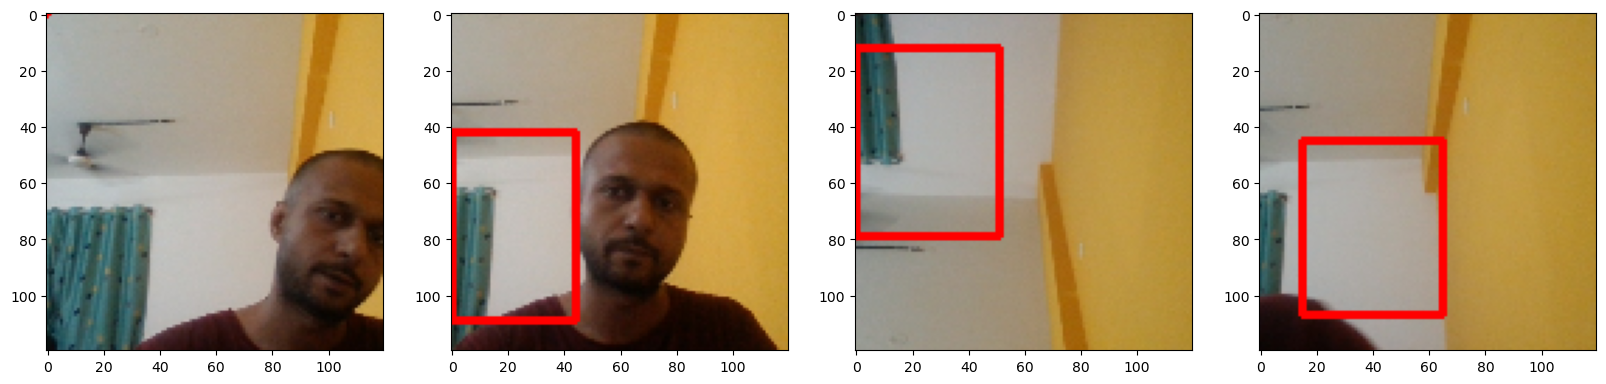

In [54]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample_image = res[0][idx].copy()
    sample_coords = res[1][1][idx]
    cv2.rectangle(sample_image,
                 tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                 tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                 (255, 0, 0), 2)
    ax[idx].imshow(sample_image)

### 8. Build Deep Learning using the Functional API

#### 8.1 Import Layers and Base Network

In [55]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.losses import BinaryCrossentropy

#### 8.2 Download VGG16

In [56]:
vgg = VGG16(include_top=False)

In [57]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

#### 8.3 Build Instance of Network

In [58]:
def build_model():
    input_layer = Input(shape=(120,120,3))
    vgg = VGG16(include_top=False)(input_layer)

    # Classification model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    # Bounding Box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

#### 8.4 Test out Neural Network

In [59]:
facetracker = build_model()

In [60]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [61]:
X, y = train.as_numpy_iterator().next()

In [62]:
X

array([[[[2.86642164e-01, 2.29473040e-01, 2.45588228e-01],
         [2.40196079e-01, 1.94117650e-01, 1.93137258e-01],
         [2.36274511e-01, 1.98529407e-01, 1.86274514e-01],
         ...,
         [2.67647058e-01, 1.89215690e-01, 1.53921574e-01],
         [2.65870094e-01, 1.77144602e-01, 1.45281866e-01],
         [2.78370112e-01, 1.75551474e-01, 1.48100495e-01]],

        [[2.82536775e-01, 2.32046574e-01, 2.26654410e-01],
         [2.84497559e-01, 2.41360292e-01, 2.25551471e-01],
         [2.68627465e-01, 2.25490198e-01, 2.08823532e-01],
         ...,
         [2.63664216e-01, 1.85232848e-01, 1.49938732e-01],
         [2.77941167e-01, 1.80882350e-01, 1.52941182e-01],
         [2.92830884e-01, 1.82046562e-01, 1.57046571e-01]],

        [[3.06740195e-01, 2.63602942e-01, 2.55759805e-01],
         [3.36213231e-01, 2.93075979e-01, 2.77389705e-01],
         [3.10232848e-01, 2.67095596e-01, 2.44424015e-01],
         ...,
         [2.86213249e-01, 1.96017161e-01, 1.64644614e-01],
         [

In [63]:
y

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0]], dtype=uint8),
 array([[0.435   , 0.0168  , 0.987   , 0.5483  ],
        [0.011086, 0.1997  , 0.527   , 0.892   ],
        [0.134   , 0.10333 , 0.6016  , 0.6626  ],
        [0.2145  , 0.1132  , 0.654   , 0.657   ],
        [0.      , 0.3748  , 0.31    , 0.9214  ],
        [0.1626  , 0.3403  , 0.5864  , 0.9023  ],
        [0.4575  , 0.06244 , 0.889   , 0.6245  ],
        [0.      , 0.      , 0.      , 0.      ]], dtype=float16))

In [64]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 1s/step


In [65]:
classes, coords

(array([[0.20547652],
        [0.23279123],
        [0.27828935],
        [0.30750203],
        [0.27091908],
        [0.28029004],
        [0.3139714 ],
        [0.30609354]], dtype=float32),
 array([[0.6192617 , 0.45626453, 0.5934798 , 0.56441385],
        [0.5499211 , 0.46304518, 0.5214541 , 0.60756236],
        [0.71755844, 0.43371776, 0.5031704 , 0.61807686],
        [0.58881795, 0.46177173, 0.5451593 , 0.50745696],
        [0.6597755 , 0.53186715, 0.56973875, 0.54856354],
        [0.53859127, 0.3953628 , 0.5910561 , 0.5457442 ],
        [0.5409777 , 0.4340184 , 0.5339213 , 0.50171304],
        [0.6637899 , 0.42803487, 0.5840539 , 0.49617434]], dtype=float32))

### 9. Define Losses and Optimizers 

#### 9.1 Define Optimizer and LR

In [66]:
len(train)

295

In [67]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 - 1)/batches_per_epoch

In [68]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

#### 9.2 Create Localization Loss and Classification Loss

In [69]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:, :2] - yhat[:, :2]))
    h_true = y_true[:, 3] - y_true[:, 1]
    w_true = y_true[:, 2] - y_true[:, 0]

    h_pred = yhat[:, 3] - yhat[:, 1]
    w_pred = yhat[:, 2] - yhat[:, 0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))

    return delta_coord + delta_size

In [70]:
classloss = BinaryCrossentropy()
regressloss = localization_loss

#### 9.3 Test out Loss Metrics

In [71]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.063863>

In [73]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=1.2000172>

In [74]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.063863>

### 10. Train Neural Network 

#### 10.1 Create Custom Model Class

In [75]:
class FaceTracker(Model):
    def __init__(self, facetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_tep(self, batch, **kwargs):
        X, y = batch
        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss + 0.5*batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss": total_loss, "class loss": batch_classloss, "regress_loss": batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch
        classes, coords = self.model(X, training=False)
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [76]:
model = FaceTracker(facetracker)

In [78]:
model.compile(opt, classloss, regressloss)

#### 10.2 Train

In [79]:
logdir = 'logs'

In [80]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [81]:
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/40


ValueError: in user code:

    File "/home/john/miniconda3/envs/dlenv/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/john/miniconda3/envs/dlenv/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/john/miniconda3/envs/dlenv/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/john/miniconda3/envs/dlenv/lib/python3.9/site-packages/keras/engine/training.py", line 1052, in train_step
        self._validate_target_and_loss(y, loss)
    File "/home/john/miniconda3/envs/dlenv/lib/python3.9/site-packages/keras/engine/training.py", line 1016, in _validate_target_and_loss
        raise ValueError(

    ValueError: No loss found. You may have forgotten to provide a `loss` argument in the `compile()` method.
